### Contexto

---

Rede Neural do tipo *Time Delay* com $n_p$ entradas $x(t-1)$, $x(t-2)$, etc. a depender do intervalo temporal histórico e $n_1$ neurônios em uma camada intermediária e 1 neurônio na camada de saída para $y = x(t)$.

Objetivo: Previsão do comportamento futuro do preço de uma determina mercadoria do mercado financeiro de ações.

Algoritmo de aprendizagem/ajuste: *backpropagation* e *momentum*. 

<img src="Fig/EPC5_Topologia_TDNN_Projeto3.jpg" width="600">


### Bibliotecas utilizadas

---

In [270]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

### Tratamento dos dados

---

In [393]:
# Leitura dos dados

data = pd.read_csv('data_510_RNA.txt', delim_whitespace=True)

In [394]:
data.index = range(1, len(data) + 1)

data

,f(t)
1,0.1701
2,0.1023
3,0.4405
4,0.3609
5,0.7192
...,...
96,0.0195
97,0.4366
98,0.0924
99,0.7984


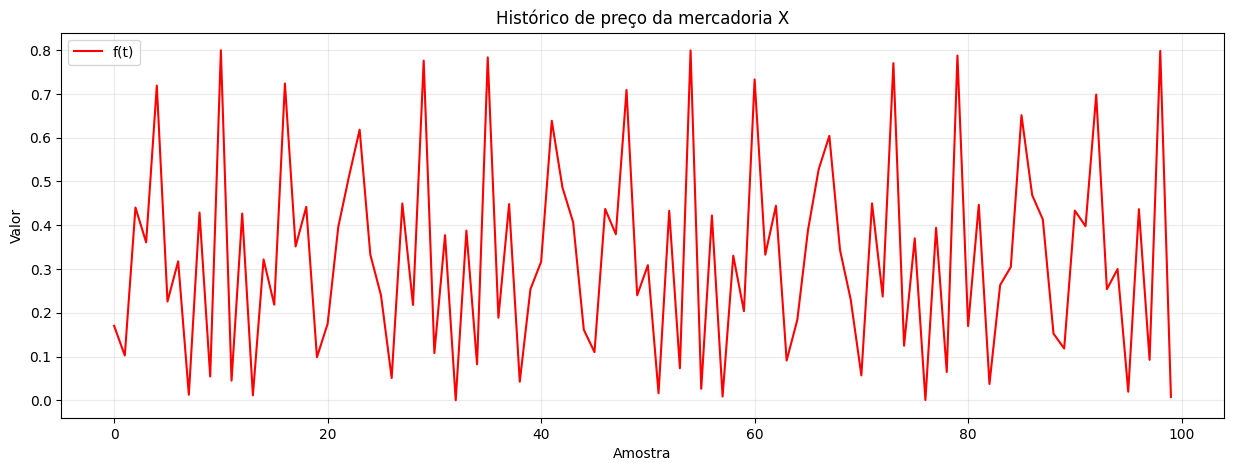

In [199]:
plot = data.plot(y='f(t)', figsize=(15, 5), color = '#FF0000')
plot.grid(alpha=0.25)
plt.xlabel('Amostra')
plt.ylabel('Valor')
plt.title('Histórico de preço da mercadoria X')
plt.savefig(f'Fig/EPC5_historico_data.pdf', format='pdf')
plt.show()

In [202]:
# Verifica a normalizacao

min = data.values.min()
max = data.values.max()

print(f'min = {min} \n max = {max}')

min = 0.0001 
 max = 0.8


Já normalizado, valores entre 0 e 1

### Função que reordenada o vetor de dados históricos em tabela para a TDNN

In [503]:
## DATA
# X -> dados historicos

## NN STRUCTURE
# np -> num. de entradas

def dataframe_to_TDNN(X, Np):

    # tamanho da amostra temporal
    N = len(X)

    # Ajustando o index para 1...N
    X.index = range(1, N + 1)
    X = X.T
    # print(X)

    # Define numero de linhas
    n_rows = (N - Np)
    
    # Cria a tabela com o index entre
    # (Np+1) <= t <= N
    df_train = pd.DataFrame(index=range((Np+1), (N+1)))

    # Preenchendo a tabela com os dados atrasados segundo Np e d (saida desejada)
    for i in df_train.index:

        for j in range(1, (Np)+1):

            df_train.loc[i, j] = float(X[i-j])
            
        df_train.loc[i, 'd'] = float(X[i])

    # renomeando as colunas
    column_names = [f'x{n}' for n in range(1, Np + 1)] + ['d']

    df_train.columns = column_names

    # Separando entre entrada e saida
    lista_columns = []

    for c in column_names:

        column = df_train[c].copy()

        lista_columns.append(column)

    df_entradas = pd.concat(lista_columns[:Np], axis=1)
    df_alvo = pd.DataFrame(lista_columns[-1])

    return df_train, df_entradas, df_alvo

### Algoritmo de Treinamento da rede neural TDNN

---

In [205]:
# valor maximo de epocas
MAX_EPOCA = int(10e+6)

# Taxa de aprendizado
n = 0.1

# Fator de momentum
m = 0.8

# Precisao
p = 0.5*10e-6

Funcao logistica (sigmoide):

$f(u) = 1 / (1 + e^{(-β*u)})$

sendo $β$ o fator de inclinacao da funcao e $u$ a entrada

In [206]:
def func_ativacao(u, beta):

    g = 1 / (1 + np.exp(-beta * u))

    return g

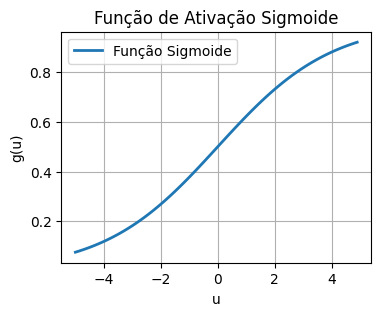

In [207]:
# Plot Funcao de Ativacao

u = np.arange(-5,5,0.1)
resultado = func_ativacao(u, 0.5)

plt.figure(figsize=(4, 3))
plt.plot(u, resultado, label='Função Sigmoide', linewidth=2)
plt.xlabel('u')
plt.ylabel('g(u)')
plt.title('Função de Ativação Sigmoide')
plt.grid(True)
plt.legend()
plt.show()

In [208]:
def func_ativacao_derivada(u, beta):
    
    gd = (beta * np.exp(-beta * u))/((np.exp(-beta * u) + 1) ** 2)

    return gd

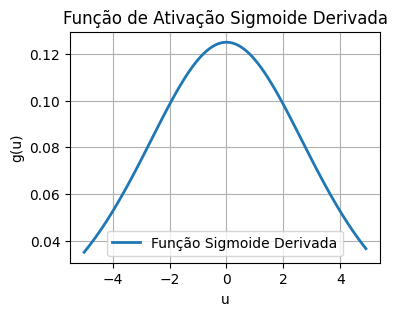

In [209]:
# Plot Funcao de Ativacao Derivada

u = np.arange(-5,5,0.1)
resultado = func_ativacao_derivada(u, 0.5)

plt.figure(figsize=(4, 3))
plt.plot(u, resultado, label='Função Sigmoide Derivada', linewidth=2)
plt.xlabel('u')
plt.ylabel('g(u)')
plt.title('Função de Ativação Sigmoide Derivada')
plt.grid(True)
plt.legend()
plt.show()

In [461]:
## DATA
# data -> dados historicos

## PARAMETERS
# n -> taxa de aprendizado
# m -> fator de momentum
# p -> precisao
# beta -> inclinacao da funcao de ativao
# MAX_EPOCA -> épocas máximas de treinamento

## NN STRUCTURE
# Nt -> num. de treinamentos
# Np -> num. de entradas
# Ni -> num. de neuronio na H.L. 1 (H.L. = camada escondida)

def treinamento_TDNN(data, n, m, p, beta, MAX_EPOCA, Nt, Np, Ni):

    data_yn = data.copy()

    N = len(data)

    # Selecionando as ultimas Np amostras dos dados historicos (X)
    data_train, df_entradas, df_alvo = dataframe_to_TDNN(data, Np)

    # Adiciona coluna do limiar de ativacao = -1 (bias) no conjunto de dados
    df_entradas['bias'] = -1

    # Transformando os dataframes em array's
    X = np.array(df_entradas)
    d = np.array(df_alvo)
    d = d.reshape(-1, 1)

    # Lista de matrizes de pesos sinapticos iniciais (i) e ajustados (adj) de cada camada
    lista_Wi_1 = []
    lista_Wi_2 = []

    lista_W_1_adj = []
    lista_W_2_adj = []

    # Lista com as saidas de cada treino
    lista_y = []
    
    # Inicializando os treinamentos
    for n_treino in range(Nt):

        print('-'*30)
        print(f'Treinamento TDD (Np = -{Np}) numero: {n_treino + 1}')
        print('-'*30)
        
        # Contador de epocas
        epoca = 0

        # Vetor de erros
        lista_erros = np.zeros(MAX_EPOCA)
        # E(t) = x(t) - y(t), onde (Np+1) <= t <= N
        # sendo N = len(X)
        # portanto: Erro = d(t) - y(t)

        # Pesos aleatorios entre 0 e 1 do {n_treino}
        # (Ni, 1) -> (Ni neuronios, Np entrada + 1 bias)
        W_1 = np.random.randn(Ni, (Np+1))
        lista_Wi_1.append(W_1)

        # Pesos aleatorios entre 0 e 1 do n_treino
        # (1, Ni) -> (1 neuronios, Ni entradas)
        W_2 = np.random.randn(1, (Ni+1))
        lista_Wi_2.append(W_2)

        # matriz sinaptica anterior = atual (para a primeira epoca)
        W_1_ant = W_1
        W_2_ant = W_2

        while(epoca < MAX_EPOCA):

            # print(f'epoca {epoca}')

            #######################
            # ETAPAS FEED FORWARD #
            #######################
            
            # **CAMADA 1 - HIDDEN**

            # Entrada I_1 = X * W_1
            I_1 = X.dot(W_1.T)

            # Saida Y_1 = g(I_1)
            Y_1 = func_ativacao(I_1, beta)
            
            # **CAMADA 2 - OUT**

            # Adicao do bias
            Y_1 = pd.DataFrame(Y_1)
            Y_1['bias'] = -1
            Y_1 = np.array(Y_1)

            # Entrada I_2 = Y_1 * W_2
            I_2 = (Y_1).dot(W_2.T)

            # Saida Y_2 = g(I_2)
            Y_2 = func_ativacao(I_2, beta)

            # Erro da previsao FOWARD
            lista_erros[epoca] = np.mean((d - Y_2) ** 2)
            
            ######################
            # ETAPAS DE BACKWARD #
            ######################

            # **CAMADA 2 - OUT**

            # ta = termo de aprendizagem

            # tm = termo de momentum

            gd_2 = func_ativacao_derivada(I_2, beta)
            erro_2 = d - Y_2
            delta_2 = erro_2 * gd_2
            
            ta_2 = ((n * delta_2).T).dot(Y_1)

            tm_2 = m * (W_2 - W_2_ant)

            W_2_adj = W_2 + tm_2 + ta_2
            
            # **CAMADA 1 - HIDDEN**

            gd_1 = func_ativacao_derivada(I_1, beta)

            delta_1 = (delta_2.dot(W_2_adj[:, :-1])) * gd_1

            ta_1 = ((n * delta_1).T).dot(X)

            tm_1 = m * (W_1 - W_1_ant)

            W_1_adj = W_1 + tm_1 + ta_1

            #########################################
            # Calculo das saidas ajustadas Y_2_n_bp #
            #########################################

            I_1_bp = X.dot(W_1_adj.T)
            Y_1_bp = func_ativacao(I_1_bp, beta)

            # Adicao do bias
            Y_1_bp = pd.DataFrame(Y_1_bp)
            Y_1_bp['bias'] = -1
            Y_1_bp = np.array(Y_1_bp)

            I_2_bp = (Y_1_bp).dot(W_2_adj.T)
            Y_2_bp = func_ativacao(I_2_bp, beta)

            # Erro da previsao PÓS-BACKWARD
            lista_erros[epoca + 1] = np.mean((d - Y_2_bp) ** 2)

            # Incremente de epoca
            epoca = epoca + 1

            # print(f'epoca{epoca} - {abs(erro[epoca] - erro[epoca - 1])} < {p}')

            # Busca pela precisao
            if (abs(lista_erros[epoca] - lista_erros[epoca - 1]) < p):

                print(f'Convergência em {epoca} épocas')
                print(f'Erro Médio Quadrático = {np.mean(lista_erros)}')

                # Armazena as matrizes de pesos sinapticos ajustados na lista
                lista_W_1_adj.append(W_1_adj)
                lista_W_2_adj.append(W_2_adj)

                # Armazena as saida pos back-propagation with momentum
                y_calc = pd.DataFrame(Y_2_bp, index=range((Np+1), (N+1)))
            
                lista_y.append(y_calc)
                
                # Grafico do erro
                plt.figure()
                plt.plot(np.arange(epoca+1), lista_erros[:epoca+1], linewidth=1)
                ttl = f'Erro pelas épocas (Treinamento {n_treino + 1})'
                plt.title(ttl)
                plt.ylabel('Erro Quadrático Médio')
                plt.xlabel('Épocas')
                
                plt.xlim(0, epoca)
                plt.ylim(0, 1)
                plt.grid()
                plt.savefig(f'Fig/EPC5_n_treino{n_treino + 1}_Np{Np}.pdf', format='pdf')
                plt.show()

                break

            # Atualiza as matrizes iniciais com as ajustadas
            W_1_ant = W_1 
            W_2_ant = W_2

            W_1 = W_1_adj
            W_2 = W_2_adj


    # Alocando os valores de treinamento no dataframe de treinamento
    for c in range(len(lista_y)):
        data_yn[c] = lista_y[c]

    column_names = ['f(t)'] + [f'y{n}' for n in range(1, Nt + 1)]

    data_yn.columns = column_names

    return data_train, data_yn, lista_W_1_adj, lista_W_2_adj

In [410]:
# Funcao para plotar o historico e seus valores calculados

def plot_historico(data, n, file_name):

    variable_names = data.columns[-n:]

    plot = data.plot(y=variable_names, figsize=(15, 5))
    plot.grid(alpha=0.25)
    plt.xlabel('Amostra')
    plt.ylabel('Valor')
    plt.title('Histórico de preço da mercadoria X e previtos')
    plt.legend(variable_names)

    plt.savefig(f'Fig/{file_name}.pdf', format='pdf')

    plt.show()

### Treinamento da rede neural TDNN

---

Atraso temporal de 5 amostras >> Np = 5 

------------------------------
Treinamento TDD (Np = -5) numero: 1
------------------------------
Convergência em 875 épocas
Erro Médio Quadrático = 9.580541243423356e-07


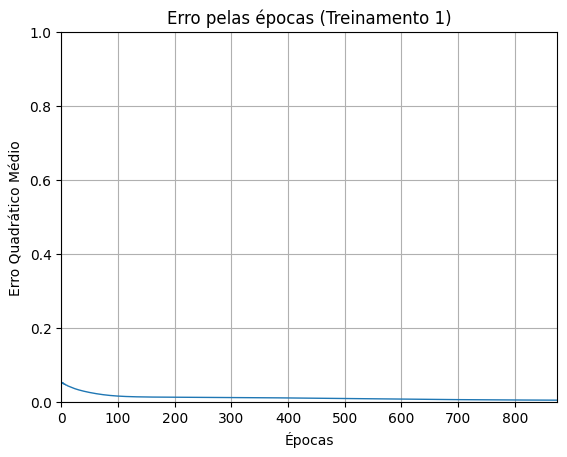

------------------------------
Treinamento TDD (Np = -5) numero: 2
------------------------------
Convergência em 189 épocas
Erro Médio Quadrático = 4.035061514221255e-07


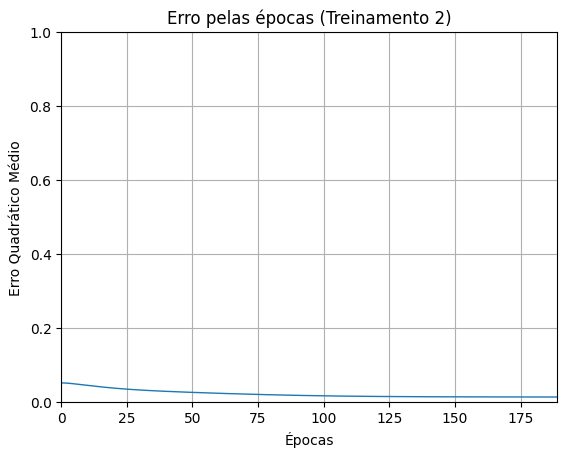

------------------------------
Treinamento TDD (Np = -5) numero: 3
------------------------------
Convergência em 764 épocas
Erro Médio Quadrático = 8.023621785807037e-07


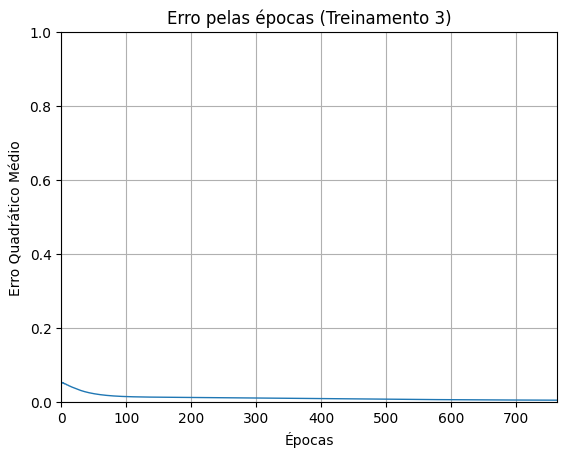

In [630]:
data_train_Np5, data_ytrain_Np5, lista_W_1_adj_Np5, lista_W_2_adj_Np5 = treinamento_TDNN(data, n, m, p, 0.5, MAX_EPOCA, 3, 5, 15)

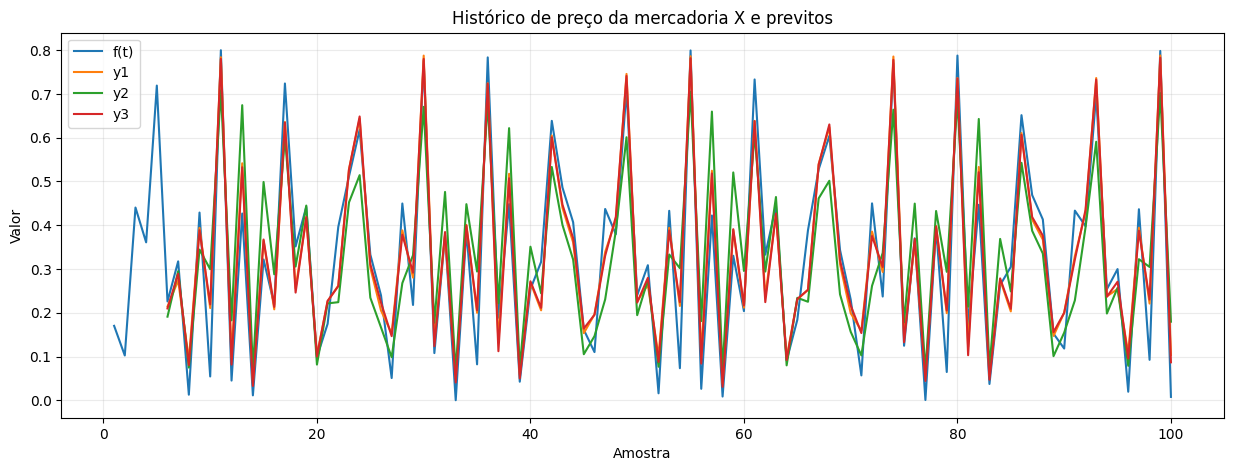

In [631]:
plot_historico(data_ytrain_Np5, 4, 'EPC5_historico_data_Np5')

Atraso temporal de 10 amostras >> Np = 10

------------------------------
Treinamento TDD (Np = -10) numero: 1
------------------------------
Convergência em 255 épocas
Erro Médio Quadrático = 3.031545539302311e-07


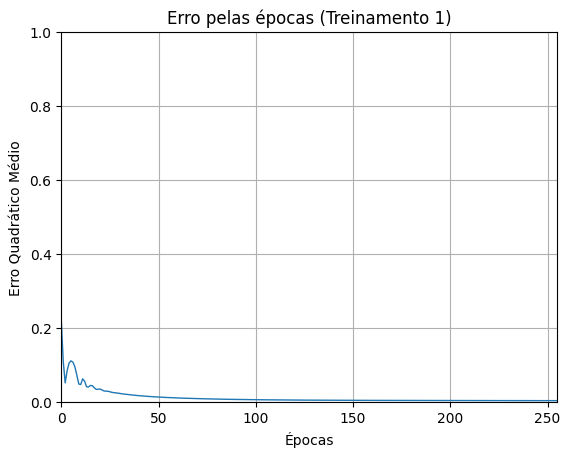

------------------------------
Treinamento TDD (Np = -10) numero: 2
------------------------------
Convergência em 227 épocas
Erro Médio Quadrático = 3.115624847253586e-07


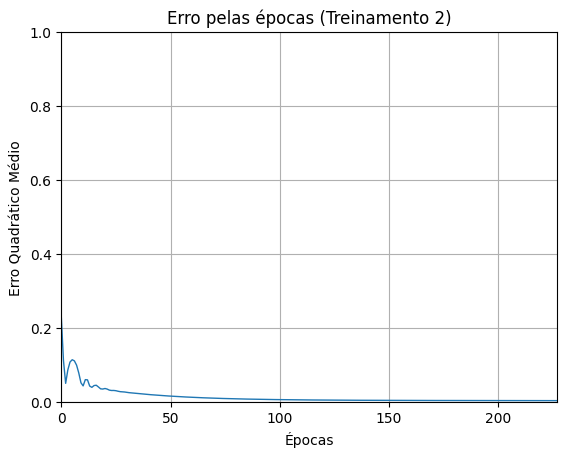

------------------------------
Treinamento TDD (Np = -10) numero: 3
------------------------------
Convergência em 290 épocas
Erro Médio Quadrático = 2.898350108113364e-07


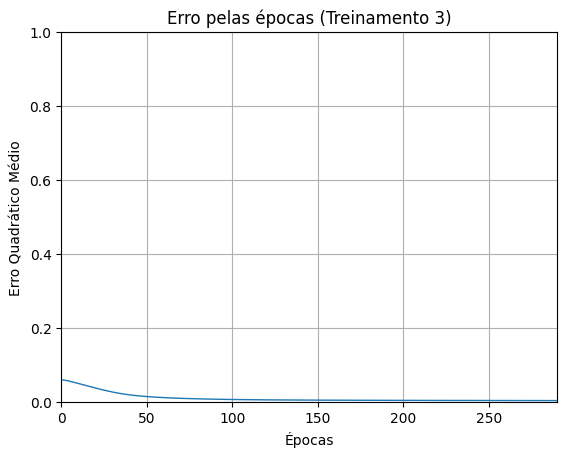

In [637]:
data_train_Np10, data_ytrain_Np10, lista_W_1_adj_Np10, lista_W_2_adj_Np10 = treinamento_TDNN(data, n, m, p, 0.5, MAX_EPOCA, 3, 10, 15)

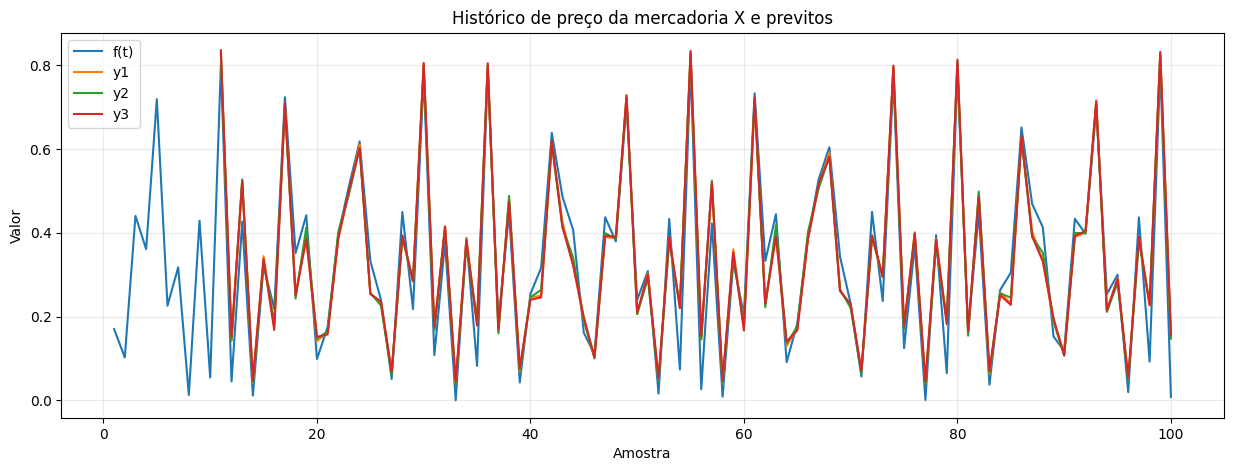

In [638]:
plot_historico(data_ytrain_Np10, 4, 'EPC5_historico_data_Np10')

Atraso temporal de 15 amostras >> Np = 15

------------------------------
Treinamento TDD (Np = -15) numero: 1
------------------------------
Convergência em 222 épocas
Erro Médio Quadrático = 1.749200214010162e-07


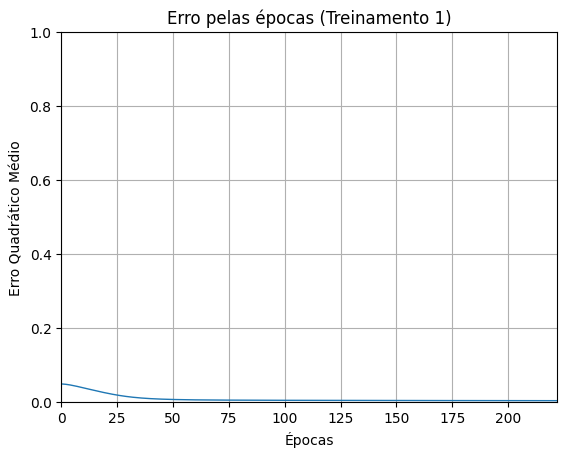

------------------------------
Treinamento TDD (Np = -15) numero: 2
------------------------------
Convergência em 246 épocas
Erro Médio Quadrático = 1.658091486450101e-07


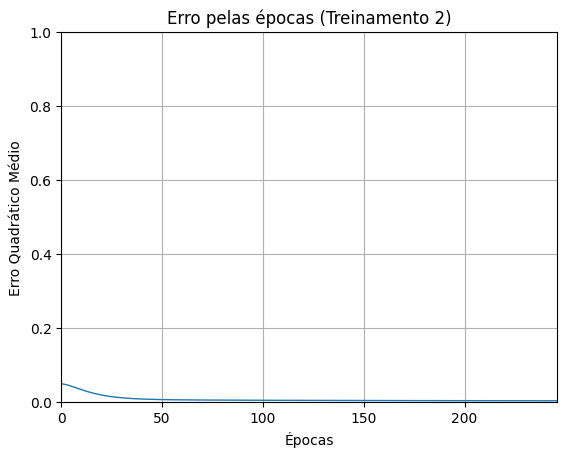

------------------------------
Treinamento TDD (Np = -15) numero: 3
------------------------------
Convergência em 244 épocas
Erro Médio Quadrático = 2.762400028990944e-07


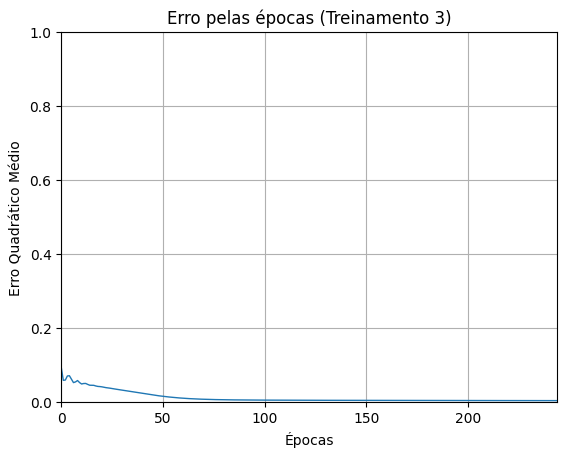

In [643]:
data_train_Np15, data_ytrain_Np15, lista_W_1_adj_Np15, lista_W_2_adj_Np15 = treinamento_TDNN(data, n, m, p, 0.5, MAX_EPOCA, 3, 15, 15)

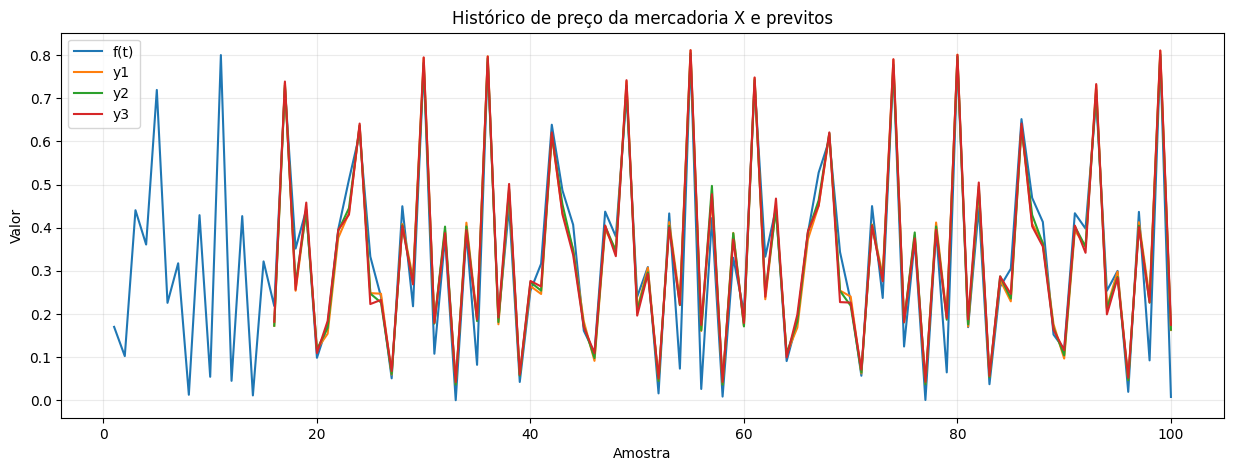

In [644]:
plot_historico(data_ytrain_Np15, 4, 'EPC5_historico_data_Np15')

### Algoritmo de Teste da rede neural TDNN

---

In [445]:
data_teste = pd.read_csv('data_teste_510_RNA.txt', delim_whitespace=True)

In [449]:
data_teste.index = range(len(data) + 1, len(data) + len(data_teste) + 1)

data_teste

,x(t)
101,0.4173
102,0.0062
103,0.3387
104,0.1886
105,0.7418
106,0.3138
107,0.4466
108,0.0835
109,0.1930
110,0.3807


In [675]:
def dataframe_to_test(data, data_teste, Np):

    data_Np = data[-Np:]
    data_Np.columns = ['x(t)']

    array_train = pd.concat([data_Np, data_teste], axis=0, ignore_index=False)

    df_teste, df_teste_entradas, df_teste_alvo = dataframe_to_TDNN(array_train, Np)

    df_teste.index = range(len(data) + 1, len(data) + len(data_teste) + 1)

    return df_teste, df_teste_entradas, df_teste_alvo

In [676]:
def teste(X_teste, lista_W_1_adj, lista_W_2_adj, beta, n_treino):

    X_teste = np.array(X_teste)

    #######################
    # ETAPAS FEED FORWARD #
    #######################
    
    # entradas I_1 e saida Y_1 da camada 1

    I_1 = X_teste.dot(lista_W_1_adj[n_treino].T)

    Y_1 = func_ativacao(I_1, beta)

    # Adicao do bias
    Y_1 = pd.DataFrame(Y_1)
    Y_1['bias'] = -1
    Y_1 = np.array(Y_1)
    
    # entrada I_2 e saida Y_2 da camada 2 de saída

    I_2 = (Y_1).dot(lista_W_2_adj[n_treino].T)

    Y_2 = func_ativacao(I_2, beta)

    return Y_2

In [677]:
def app_teste(data, data_teste, lista_W_1_adj, lista_W_2_adj, beta, Nt, Np):

    lista_ytest = []

    # Prepara a matriz para os calculos
    data_teste, df_teste_entradas, df_teste_alvo = dataframe_to_test(data, data_teste, Np)
    
    X_teste = df_teste_entradas.copy()
    X_teste['bias'] = -1
    X_teste = np.array(X_teste)

    data_yteste = df_teste_alvo.copy()
    d_teste = np.array(df_teste_alvo)
    d_teste = d_teste.reshape(-1, 1)
    
    # Realiza o teste para cada treinamento
    for i in range(Nt):

        print('-'*30)
        print(f'Teste TDD (Np = -{Np}) numero: {i + 1}')
        print('-'*30)

        Y_2 = teste(X_teste, lista_W_1_adj, lista_W_2_adj, beta, i)

        y_calc = pd.DataFrame(Y_2, index=range(len(data) + 1, len(data) + len(data_teste) + 1))
            
        lista_ytest.append(y_calc)

        # Erro relativo medio e variancia
        erro = np.mean(((np.abs(d_teste - Y_2))/(np.abs(d_teste)))*100)
        variancia = (np.sum((d_teste - Y_2) ** 2))/(len(d_teste)-1)

        print(f'Erro Relativo Médio {i + 1} = {erro}')
        print(f'Variancia {i + 1} = {variancia}')

    # Prepara a tabela de saida com os valores alvo e os calculas
    data_yteste.index = range(len(data) + 1, len(data) + len(data_teste) + 1)

    for c in range(len(lista_ytest)):
        data_yteste[c] = lista_ytest[c]

    column_names = ['x(t)'] + [f'(T{n})' for n in range(1, Nt + 1)]

    data_yteste.columns = column_names

    return data_yteste

### Teste da rede neural TDNN

---

Atraso temporal de 5 amostras >> Np = 5

In [691]:
data_yteste_Np5 = app_teste(data, data_teste, lista_W_1_adj_Np5, lista_W_2_adj_Np5, 0.5, 3, 5)

data_yteste_Np5

------------------------------
Teste TDD (Np = -5) numero: 1
------------------------------
Erro Relativo Médio 1 = 45.7644105846803
Variancia 1 = 0.00402742828858927
------------------------------
Teste TDD (Np = -5) numero: 2
------------------------------
Erro Relativo Médio 2 = 77.18320190036134
Variancia 2 = 0.0131352536172733
------------------------------
Teste TDD (Np = -5) numero: 3
------------------------------
Erro Relativo Médio 3 = 37.793529397396966
Variancia 3 = 0.004137726693911186


,x(t),(T1),(T2),(T3)
101,0.4173,0.508224,0.644581,0.504729
102,0.0062,0.037479,0.065776,0.029029
103,0.3387,0.414891,0.541989,0.415549
104,0.1886,0.216315,0.303840,0.220729
105,0.7418,0.640933,0.618134,0.641097
106,0.3138,0.218132,0.283125,0.204129
107,0.4466,0.435131,0.484567,0.435468
108,0.0835,0.090373,0.078229,0.084373
109,0.1930,0.234929,0.247754,0.236157
110,0.3807,0.243525,0.226346,0.244551


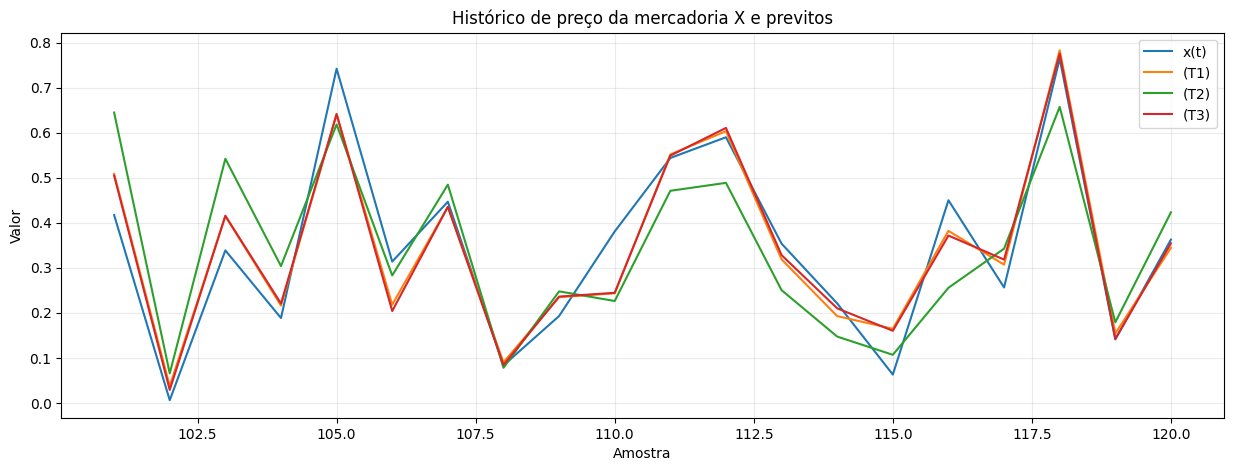

In [650]:
plot_historico(data_yteste_Np5, 4, 'EPC5_historico_teste_Np5')

Atraso temporal de 10 amostras >> Np = 10

In [693]:
data_yteste_Np10 = app_teste(data, data_teste, lista_W_1_adj_Np10, lista_W_2_adj_Np10, 0.5, 3, 10)

data_yteste_Np10

------------------------------
Teste TDD (Np = -10) numero: 1
------------------------------
Erro Relativo Médio 1 = 37.48281609067406
Variancia 1 = 0.0022007154998724405
------------------------------
Teste TDD (Np = -10) numero: 2
------------------------------
Erro Relativo Médio 2 = 37.706559708491014
Variancia 2 = 0.0022515499996906135
------------------------------
Teste TDD (Np = -10) numero: 3
------------------------------
Erro Relativo Médio 3 = 44.33913027218226
Variancia 3 = 0.0023561131846893944


,x(t),(T1),(T2),(T3)
101,0.4173,0.511731,0.521415,0.515786
102,0.0062,0.037141,0.038198,0.044235
103,0.3387,0.377454,0.355886,0.369978
104,0.1886,0.174029,0.184310,0.165313
105,0.7418,0.721992,0.731504,0.733861
106,0.3138,0.211146,0.202726,0.211800
107,0.4466,0.407125,0.423724,0.397286
108,0.0835,0.119827,0.125109,0.129536
109,0.1930,0.182001,0.188251,0.177706
110,0.3807,0.383941,0.402108,0.384414


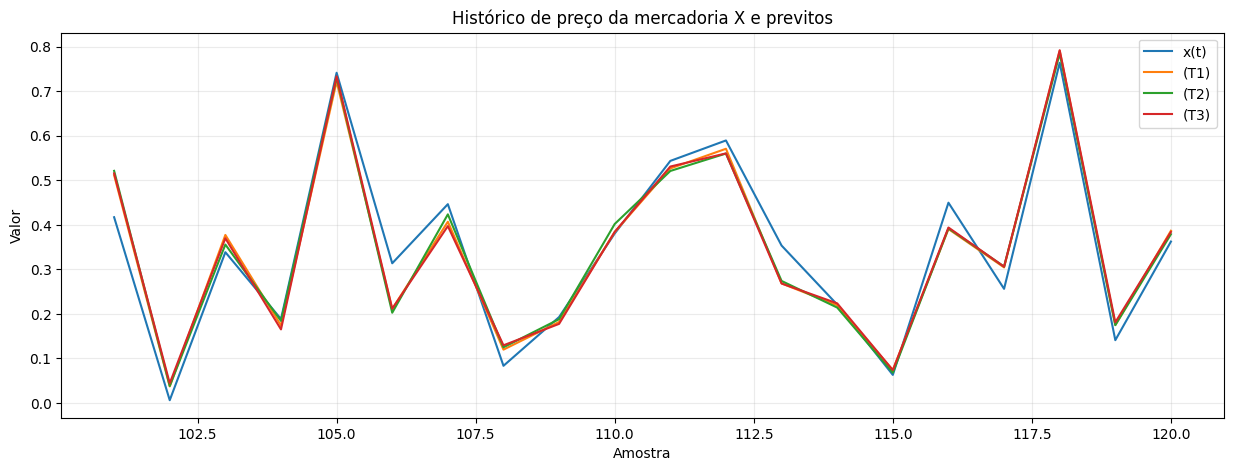

In [652]:
plot_historico(data_yteste_Np10, 4, 'EPC5_historico_teste_Np10')

Atraso temporal de 15 amostras >> Np = 15

In [695]:
data_yteste_Np15 = app_teste(data, data_teste, lista_W_1_adj_Np15, lista_W_2_adj_Np15, 0.5, 3, 15)

data_yteste_Np15

------------------------------
Teste TDD (Np = -15) numero: 1
------------------------------
Erro Relativo Médio 1 = 34.69993656955388
Variancia 1 = 0.0020186420054679197
------------------------------
Teste TDD (Np = -15) numero: 2
------------------------------
Erro Relativo Médio 2 = 33.4578811820569
Variancia 2 = 0.001891954398622111
------------------------------
Teste TDD (Np = -15) numero: 3
------------------------------
Erro Relativo Médio 3 = 39.141867650108786
Variancia 3 = 0.0021403329408050797


,x(t),(T1),(T2),(T3)
101,0.4173,0.462317,0.490728,0.467349
102,0.0062,0.036149,0.034996,0.041671
103,0.3387,0.401935,0.399204,0.384856
104,0.1886,0.171649,0.169828,0.176634
105,0.7418,0.757299,0.753431,0.756900
106,0.3138,0.215435,0.227189,0.224431
107,0.4466,0.452285,0.447773,0.476602
108,0.0835,0.097879,0.098362,0.090285
109,0.1930,0.183733,0.198455,0.213807
110,0.3807,0.370492,0.387586,0.389027


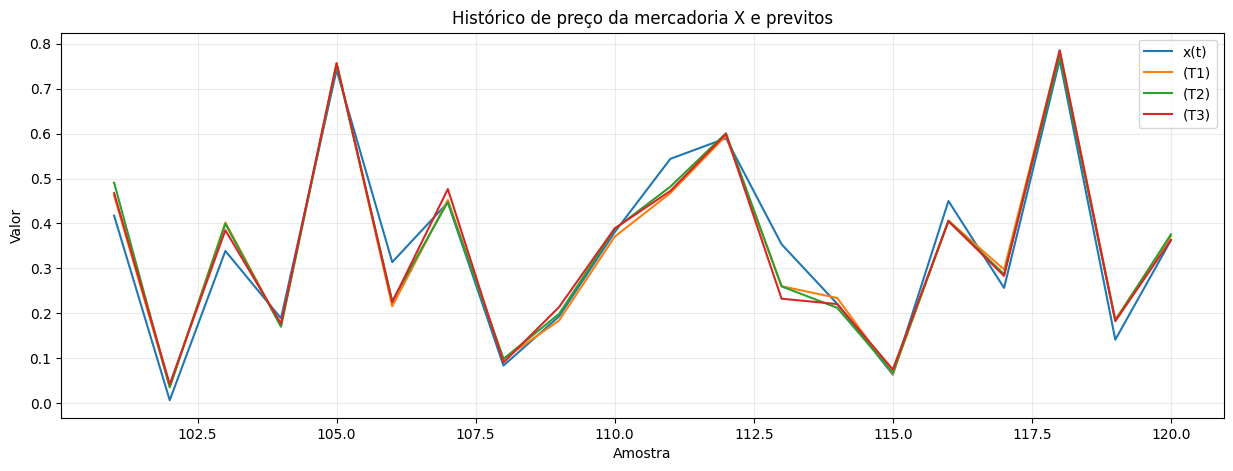

In [674]:
plot_historico(data_yteste_Np15, 4, 'EPC5_historico_teste_Np15')

### Matrizes dos Pesos Sinápticos Ajustados
---

In [668]:
for i, array in enumerate(lista_W_1_adj_Np5):

    csv_file = f'Wn_pesos/W1_adj_Np5_treino{i+1}.csv'
    np.savetxt(csv_file, array, delimiter=',')

In [669]:
for i, array in enumerate(lista_W_2_adj_Np5):

    csv_file = f'Wn_pesos/W2_adj_Np5_treino{i+1}.csv'
    np.savetxt(csv_file, array, delimiter=',')

In [670]:
for i, array in enumerate(lista_W_1_adj_Np10):

    csv_file = f'Wn_pesos/W1_adj_Np10_treino{i+1}.csv'
    np.savetxt(csv_file, array, delimiter=',')

In [671]:
for i, array in enumerate(lista_W_2_adj_Np10):

    csv_file = f'Wn_pesos/W2_adj_Np10_treino{i+1}.csv'
    np.savetxt(csv_file, array, delimiter=',')

In [672]:
for i, array in enumerate(lista_W_1_adj_Np15):

    csv_file = f'Wn_pesos/W1_adj_Np15_treino{i+1}.csv'
    np.savetxt(csv_file, array, delimiter=',')

In [673]:
for i, array in enumerate(lista_W_2_adj_Np15):

    csv_file = f'Wn_pesos/W2_adj_Np15_treino{i+1}.csv'
    np.savetxt(csv_file, array, delimiter=',')

### Gráfico com os melhores treinos de cada topologia
---

Np5 - T2

Np10 - T3

Np15 - T2

In [710]:
dados_testes_otimos_Np5 = data_yteste_Np5['(T2)']

dados_testes_otimos_Np5 = pd.DataFrame(dados_testes_otimos_Np5)

dados_testes_otimos_Np5 = dados_testes_otimos_Np5.rename(columns={'(T2)': 'TDNN 1 (T2)'})

In [713]:
dados_testes_otimos_Np10 = data_yteste_Np10['(T3)']

dados_testes_otimos_Np10 = pd.DataFrame(dados_testes_otimos_Np10)

dados_testes_otimos_Np10 = dados_testes_otimos_Np10.rename(columns={'(T3)': 'TDNN 2 (T3)'})

In [716]:
dados_testes_otimos_Np15 = data_yteste_Np15['(T2)']

dados_testes_otimos_Np15 = pd.DataFrame(dados_testes_otimos_Np15)

dados_testes_otimos_Np15 = dados_testes_otimos_Np15.rename(columns={'(T2)': 'TDNN 3 (T2)'})

In [718]:
dados_testes_otimos = pd.concat([data_teste, dados_testes_otimos_Np5, dados_testes_otimos_Np10, dados_testes_otimos_Np15], axis=1)

dados_testes_otimos

,x(t),TDNN 1 (T2),TDNN 2 (T3),TDNN 3 (T2)
101,0.4173,0.644581,0.515786,0.490728
102,0.0062,0.065776,0.044235,0.034996
103,0.3387,0.541989,0.369978,0.399204
104,0.1886,0.303840,0.165313,0.169828
105,0.7418,0.618134,0.733861,0.753431
106,0.3138,0.283125,0.211800,0.227189
107,0.4466,0.484567,0.397286,0.447773
108,0.0835,0.078229,0.129536,0.098362
109,0.1930,0.247754,0.177706,0.198455
110,0.3807,0.226346,0.384414,0.387586


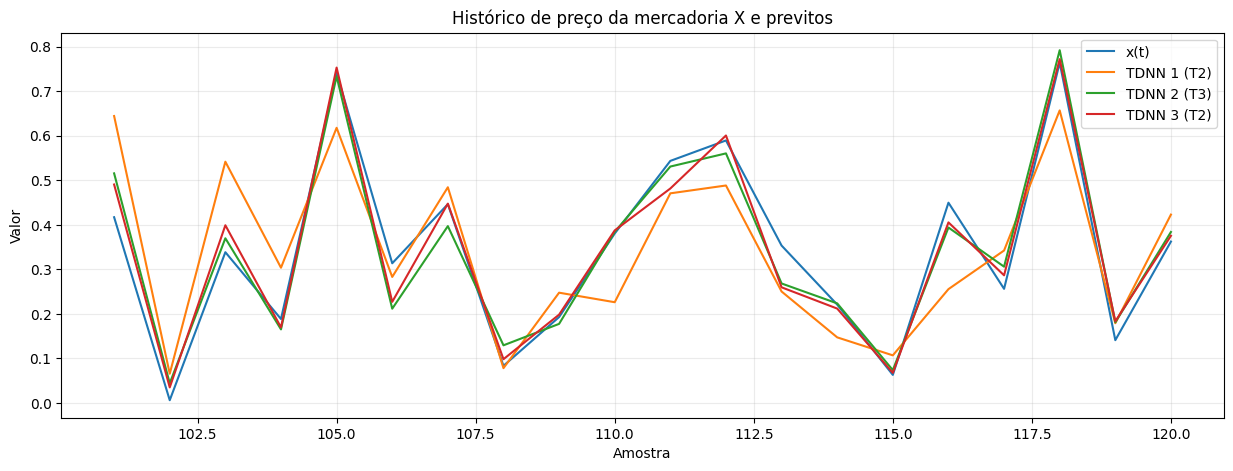

In [719]:
plot_historico(dados_testes_otimos, 4, 'EPC5_historico_teste_otimos')